# NLTK Chapter 7

## Extracting Information from Text

*The html version of this chapter in the book is available [here](https://www.nltk.org/book/ch07.html "ch07").*

### 1 Information Extraction

*If location information was stored as a list of tuples and we wanted to extract information to answer the question "Which organizations operate in Atlanta?", we could use code thusly:*

In [1]:
locs = [('Onmicom', 'IN', 'New York'),
        ('DDB Needham', 'IN', 'New York'), 
        ('Kaplan Thaler Group', 'IN', 'New York'),
        ('BBDO South', 'IN', 'Atlanta'),
        ('Georgia-Pacific', 'IN', 'Atlanta')]
query = [e1 for (e1, re1, e2) in locs if e2 == 'Atlanta']
print(query)

['BBDO South', 'Georgia-Pacific']


#### 1.1 Information Extraction Architecture



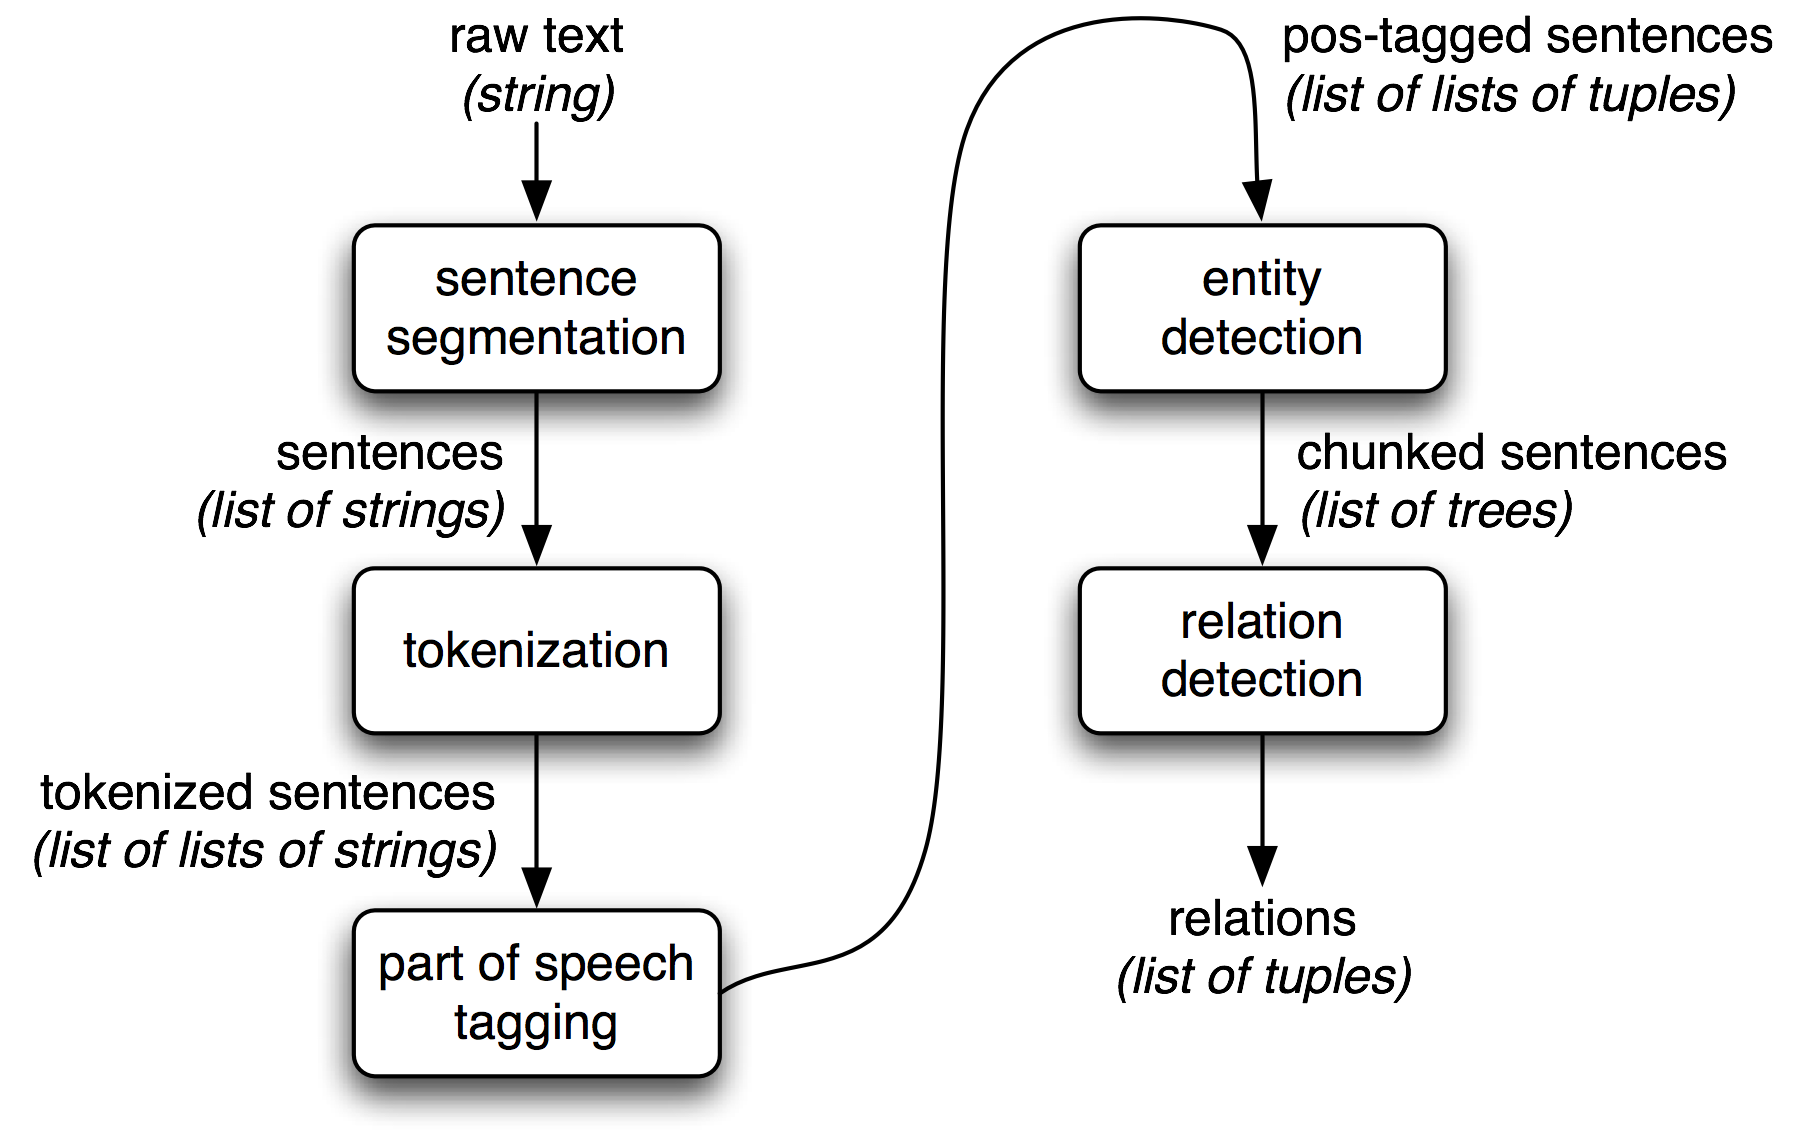

In [36]:
from IPython.display import display, Image

display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ie-architecture.png"))

*__Figure 1.1__: Simple Pipeline Architecture for an Information Extraction System. This system takes the raw text of a document as its input, and generates a list of (`entity`, `relation`, `entity`) tuples as its output. For example, given a document that indicates that the company Georgia-Pacific is located in Atlanta, it might generate the tuple `([ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta'])`.*

*The code below could perform the first three tasks:*

In [3]:
import nltk

In [4]:
def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]

### 2 Chunking

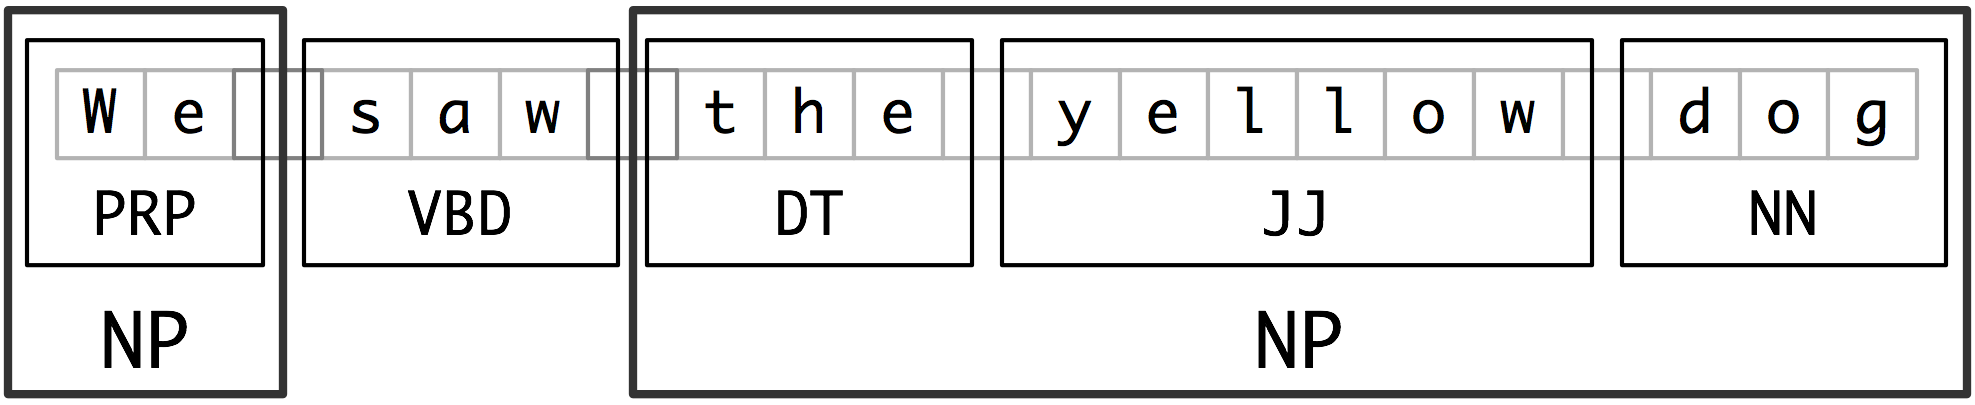

In [5]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\chunk-segmentation.png"))

*__Figure 2.1__: Segmentation and Labeling at both the Token and Chunk Levels*

#### 2.1 Noun Phrase Chunking

*Some WSJ text with `NP`-chunks marked using brackets:*

[ The/DT market/NN ] for/IN [ system-management/NN software/NN ] for/IN [ Digital/NNP ] [ 's/POS hardware/NN ] is/VBZ fragmented/JJ enough/RB that/IN [ a/DT giant/NN ] such/JJ as/IN [ Computer/NNP Associates/NNPS ] should/MD do/VB well/RB there/RB ./.

*To make a chunker, we have to define a chunk grammar:*

In [6]:
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"), 
            ("the", "DT"), ("cat", "NN")]

# look for an optional determiner, followed by any number of adjectives, 
# and a required noun
grammar = "NP: {<DT>?<JJ>*<NN>}"
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
print(result)

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


*`result.draw()` will draw the parse tree in a new window.  If I leave this cell in this notebook, none of the cells below it will run until the window is closed, so I'm not going to leave that cell in this notebook.*

*This [SO discussion](https://stackoverflow.com/questions/23429117/saving-nltk-drawn-parse-tree-to-image-file "Parse Tree to PNG") has instructions on how to convert this to a .png file, but I could not get it to work.*

*Below is the figure for the tree in the book:*

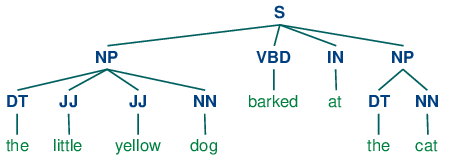

In [26]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch07-tree-1.png"))

#### 2.2 Tag Patterns

*It's difficult to come up with __tag patterns__ that will match all possible cases.*

__Your Turn__: Try to come up with tag patterns to cover the cases below. Test them using the graphical interface `nltk.app.chunkparser()`. Continue to refine your tag patterns with the help of the feedback given by this tool.

```
his/PRP$ Mansion/NNP House/NNP speech/NN
the/DT price/NN cutting/VBG
3/CD %/NN to/TO 4/CD %/NN
more/JJR than/IN 10/CD %/NN
the/DT fastest/JJS developing/VBG trends/NNS
's/POS skill/NN
```

*The chunkparser app `nltk.app.chunkparser()` opens in a new window, so this is another piece of code I can't leave in the notebook.  Basically, to cover all of the cases listed in the book, I have to include every possible tag pattern.  I can't guarantee the order of the tags will match all possible noun phrases.*

`NP:{<DT>?<PRP.>?<POS>?<TO>?<CD>?<JJ.*>*<IN>?<VBG>?<NN.*>+<VB.>?.}`

#### 2.3 Chunking with Regular Expressions

*A simple chunk grammar with two rules:*

In [2]:
import re

grammar = r"""
    NP: {<DT|PP\$>?<JJ>*<NN>} # chunk determiner/possessive, adjectives and noun
        {<NNP>+}              # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"),
            ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]
print(cp.parse(sentence))


(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


*If a tag pattern matches at overlapping locations, the leftmost match takes precedence.  E.g., below there are three consecutive nouns, but only the first two will be chunked:*

In [3]:
nouns = [("money", "NN"), ("market", "NN"), ("fund", "NN")]
grammar = "NP: {<NN><NN>}  # Chunk two consecutive nouns"
cp = nltk.RegexpParser(grammar)
print(cp.parse(nouns))

(S (NP money/NN market/NN) fund/NN)


#### 2.4 Exploring Text Corpora

*We can use chunkers to extract phrases matching a particular sequence of part-of-speech tags:*

In [8]:
cp = nltk.RegexpParser('CHUNK: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown
chunked = []

for sent in brown.tagged_sents():
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': 
            chunked.append(subtree)

In [12]:
for t in chunked[:5]:
    print(t)

(CHUNK combined/VBN to/TO achieve/VB)
(CHUNK continue/VB to/TO place/VB)
(CHUNK serve/VB to/TO protect/VB)
(CHUNK wanted/VBD to/TO wait/VB)
(CHUNK allowed/VBN to/TO place/VB)


__Your Turn__: Encapsulate the above example inside a function `find_chunks()` that takes a chunk string like `"CHUNK: {<V.*> <TO> <V.*>}"` as an argument. Use it to search the corpus for several other patterns, such as four or more nouns in a row, e.g. `"NOUNS: {<N.*>{4,}}"`

In [31]:
def find_chunks(corpus, chunk):
    """
    Returns chunks with a given set of tags from a corpus of 
    tagged sentences.
    
    Arguments:
    
    corpus: corpus of chunked sentences.
    chunk:  regular expression with POS tags. Should be in the format:
            'CHUNK_LABEL: {TAG1}{TAG2}...'. N.B. a colon (:) must separate
            the label from the tags.
    """
    chunked = []
    # retrieve label for chunks
    chunk_label = re.search(r'[^"][^:]*', chunk).group()
    cp = nltk.RegexpParser(chunk)
    for sent in corpus:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == chunk_label:
                chunked.append(subtree)
    
    return chunked

In [32]:
nouns_4Xs = find_chunks(brown.tagged_sents(), "NOUNS: {<N.*>{4,}}")
for n in nouns_4Xs[:5]:
    print(n)

(NOUNS Court/NN-TL Judge/NN-TL Durwood/NP Pye/NP)
(NOUNS Mayor-nominate/NN-TL Ivan/NP Allen/NP Jr./NP)
(NOUNS Georgia's/NP$ automobile/NN title/NN law/NN)
(NOUNS State/NN-TL Welfare/NN-TL Department's/NN$-TL handling/NN)
(NOUNS Fulton/NP-TL Tax/NN-TL Commissioner's/NN$-TL Office/NN-TL)


#### 2.5 Chinking

*A __chink__ is the opposite of a chunk: it's a sequences of tokens that is not included in a chunk.  In the example following, `barked/VBD at/IN` is a chink:*

`[ the/DT little/JJ yellow/JJ dog/NN ] barked/VBD at/IN [ the/DT cat/NN ]`

*To form a chink, put a set of tags __outside curly braces__, (e.g. `}<TAG1><TAG2>{` ).  Here's an example:*

In [33]:
grammar = r"""
 NP:
  {<.*>+}      # Chunk everything
  }<VBD|IN>+{  # Chink sequences of VBD and IN
 """
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"), ("the", "DT"),
            ("cat", "NN")]
cp = nltk.RegexpParser(grammar)
print(cp.parse(sentence))

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


#### 2.6 Representing Chunks: Tags vs Trees

*Chunks can be represented with either tags or trees.  The most common scheme uses __IOB tags__: tokens are tagged either `I` (inside), `O` (outside), or `B` (begin).  `B` marks the beginning of the chunk, and all subsequent tokens within the chunk are tagged `I`.  Anything else is tagged `O`.  `B` and `I` are suffixed with the chunk type, e.g. `B-NP`, `I-NP`.  `O` doesn't get a suffix.*

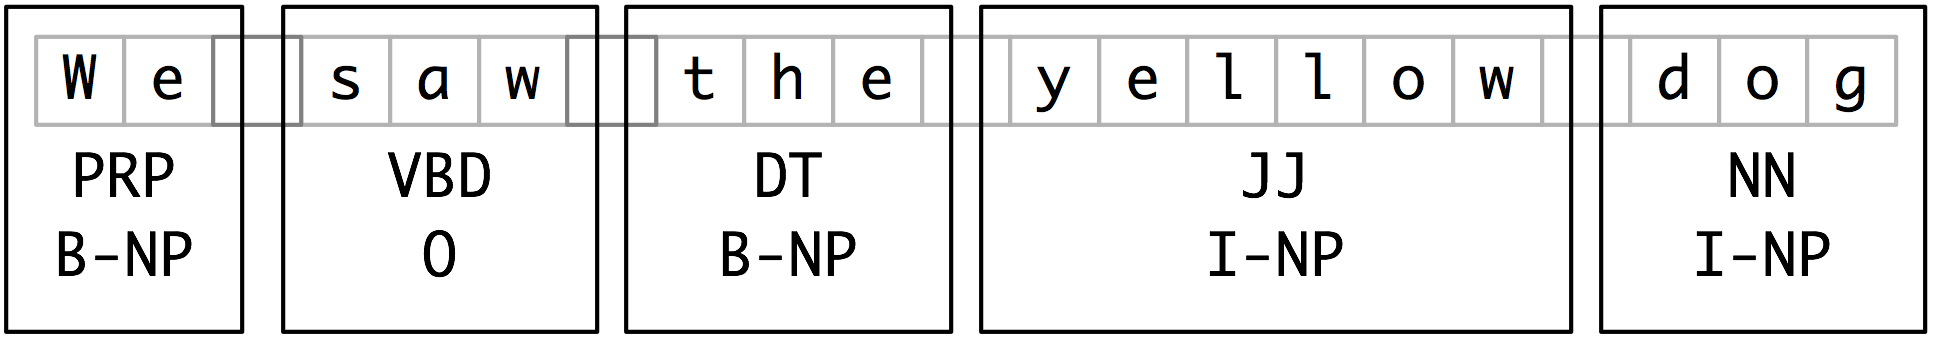

In [37]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\chunk-tagrep.png"))

*__Figure 2.5__: Tag Representation of Chunk Structures*

*This is how the information above would appear in a file:*

```
We PRP B-NP
saw VBD O
the DT B-NP
yellow JJ I-NP
dog NN I-NP

```

*Here is a chunk structure represented as a tree:*

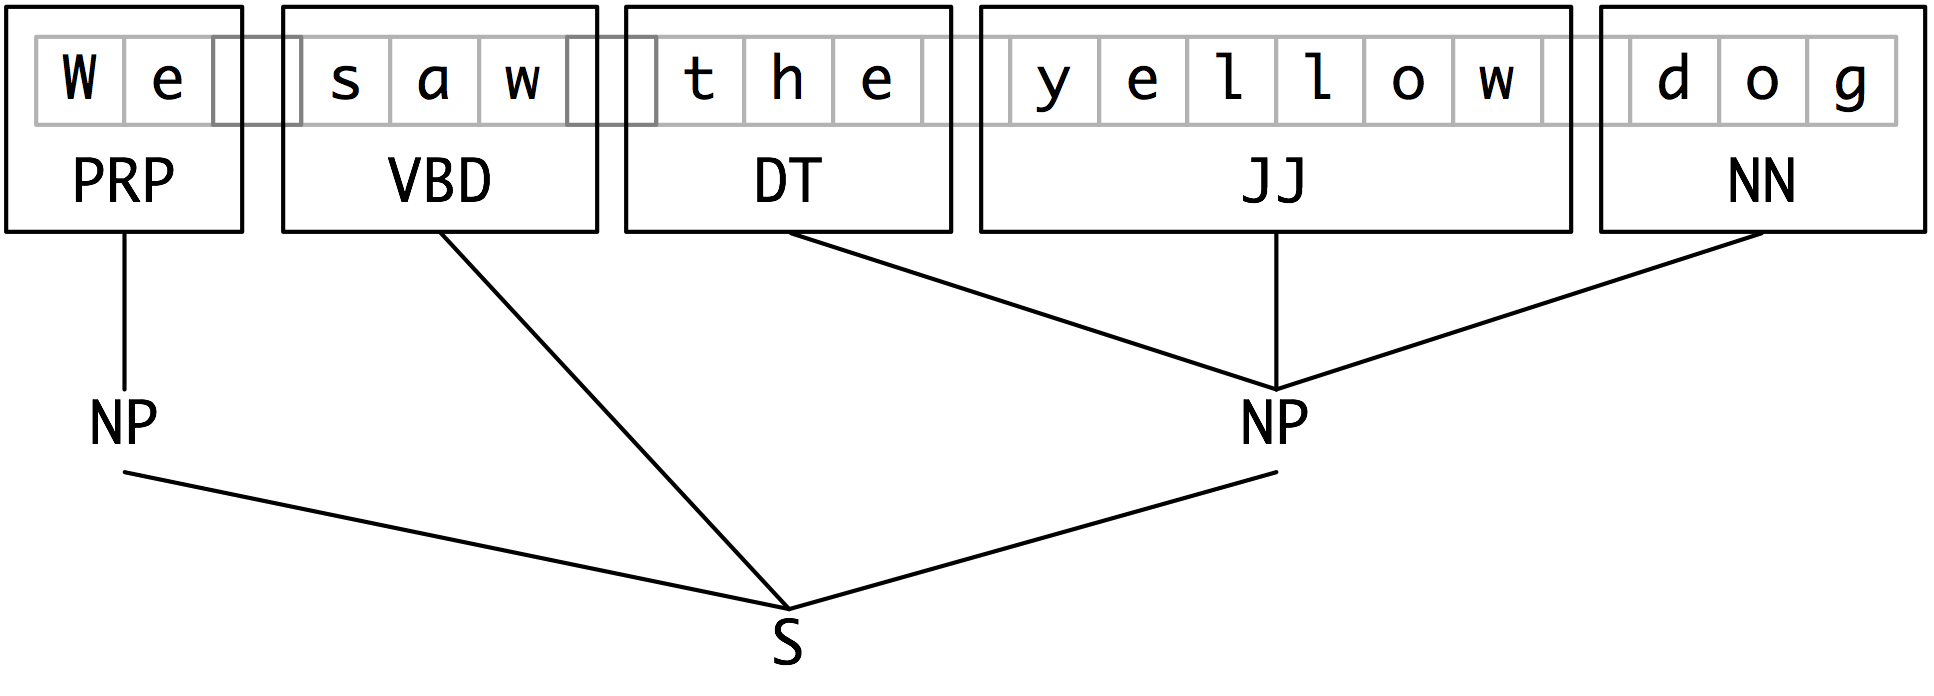

In [38]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\chunk-treerep.png"))

### 3 Developing and Evaluating Chunkers

#### 3.1 Reading IOB Format and the CoNLL 2000 Corpus

*The function `chunk.conllstr2tree()` builds a tree from IOB strings.  It also allows up to choose any subset of three chunk types to use.  The code below opens a new window, so I'm not going to include it in a code cell in this notebook:*

```
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''
nltk.chunk.conllstr2tree(text, chunk_types=['NP']).draw()
```

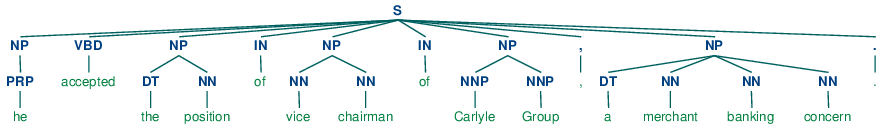

In [40]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch07-tree-2.png"))

*Looking at a sentence from the corpus:*

In [41]:
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


*Looking at just the `NP` chunks:*

In [42]:
print(conll2000.chunked_sents('train.txt', chunk_types = ['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


#### 3.2 Simple Evaluation and Baselines

*Evaluation score for a baseline parser that creates no chunks:*

In [43]:
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


*This means that 43.4% of the words are tagged `O`, or not in an `NP` chunk.*

*Here's a second regex chunker.  It's a very naive one that looks for tags that are characteristic of noun phrase tags (e.g., `CD`, `DT`, and `JJ`):*

In [44]:
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


*We could also build a __unigram tagger__ that would find the correct chunk tag (either `B`, `I`, or `O`) based on the POS tag.*

In [64]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                       for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
        
    
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)


*Train the tagger with the CoNLL 2000 corpus and test it:*

In [65]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types = ['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


*We can examine how this chunker would assign values to each of the POS tags in the corpus:*

In [66]:
postags = sorted(set(pos for sent in train_sents
                     for (word, pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


*We could just as easily make a bigram chunker:*

In [251]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                       for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)
        
    
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [71]:
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


#### 3.3 Training Classifier-Based Chunkers

*POS tags alone are not enough to chunk a sentence.  Consider these two sentences:*

* a.		Joey/NN sold/VBD the/DT farmer/NN rice/NN ./.

* b.		Nick/NN broke/VBD my/DT computer/NN monitor/NN ./.

*Although the POS tags are the same, the chunks would be different: __a.__ would have three distinct chunks, whereas __b.__ would have just two.  We therefore need information about the content of the words.  We can use a classifier to attempt to get that.*

*__N.B.:__ The code in the book has a classifier that uses the `megam` algorithm, but getting this algorithm to work is very buggy. I therefore just commented out this line, which will cause the classifier to use the default algorithm (which I think is IIS).  (Perhaps because of this,) (t)he classifier is very, very slow to run.*

In [74]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = [] 
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
                
        self.classifier = nltk.MaxentClassifier.train(train_set, 
                                                     # algorithm = 'megam', 
                                                     trace = 0)
        
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)
    
class ConsecutiveNPChunker(nltk.ChunkParserI):
    
    def __init__(self, train_sents):
        tagged_sents = [[((w, t), c) for (w, t, c) in
                          nltk.chunk.tree2conlltags(sent)]
                          for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)
        
    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w, t, c) for ((w, t), c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)
    


In [75]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}


chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


*Adding a feature for the previous POS tag:*

In [76]:
# adding feature for prevpos

def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = '<START>', '<START>'
    else:
        prevword, prevpos = sentence[i - 1]
    return {"pos": pos, "prevpos": prevpos}

chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.6%%
    Precision:     82.0%%
    Recall:        87.2%%
    F-Measure:     84.6%%


*Adding a feature for the word:*

In [79]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = '<START>', '<START>'
    else:
        prevword, prevpos = sentence[i - 1]
    return {"pos": pos, "word": word, "prevpos": prevpos}

chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  94.6%%
    Precision:     84.6%%
    Recall:        89.8%%
    F-Measure:     87.1%%


*Adding a number of different features:*

In [80]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = '<START>', '<START>'
    else:
        prevword, prevpos = sentence[i - 1]
    if i == len(sentence) - 1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextwor, nextpos = sentence[i + 1]
    
    return {"pos": pos, 
            "word": word, 
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": "%s + %s" % (prevpos, pos),
            "pos+nextpos": "%s + %s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)}

def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  96.0%%
    Precision:     88.3%%
    Recall:        91.1%%
    F-Measure:     89.7%%


__Your Turn:__ Try adding different features to the feature extractor function `npchunk_features`, and see if you can further improve the performance of the NP chunker.

*I just added all the features that were readily available but had yet not been used (i.e., `prevword` and `nextword`), and an easy-to-calculate one (`length`):*

In [103]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = '<START>', '<START>'
    else:
        prevword, prevpos = sentence[i - 1]
    if i == len(sentence) - 1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextword, nextpos = sentence[i + 1]
    
    return {"pos": pos, 
            "word": word, 
            "prevpos": prevpos,
            "prevword": prevword,
            "nextpos": nextpos,
            "nextword": nextword,
            "prevpos+pos": "%s + %s" % (prevpos, pos),
            "pos+nextpos": "%s + %s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i),
            "length": len(sentence)}

def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  96.3%%
    Precision:     89.7%%
    Recall:        92.4%%
    F-Measure:     91.0%%


*I was pleasantly surprised to see that this classifier performs slightly better than the ones exemplified in this chapter.  As mentioned above, the classifier is extremely slow.  Using trial and error to find the most useful features would be an exercise in patience that I'm not in the mood for now.*

### 4 Recursion in Linguistic Structure

#### 4.1 Building Nested Structure with Cascaded Chunkers

*We can also build deeper chunks:*


In [81]:
grammar = r"""
    NP: {<DT|JJ|NN.*>+}           # Chunk sequences of DT, JJ, NN
    PP: {<IN><NP>}                # Chunk prepositions followed by NP
    VP: {<VB.*><NP|PP|CLAUSE>+$}  # Chunk verbs and their arguments
    CLAUSE: {<NP><VP>}            # Chunk NP, VP
"""

In [82]:
cp = nltk.RegexpParser(grammar)
sentence = [("Mary", "NN"), ("saw", "VBD"), ("the", "DT"), ("cat", "NN"),
            ("sit", "VB"), ("on", "IN"), ("the", "DT"), ("mat", "NN")]
print(cp.parse(sentence))

(S
  (NP Mary/NN)
  saw/VBD
  (CLAUSE
    (NP the/DT cat/NN)
    (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))


In [83]:
sentence = [("John", "NNP"), ("thinks", "VBZ"), ("Mary", "NN"),
            ("saw", "VBD"), ("the", "DT"), ("cat", "NN"), ("sit", "VB"),
            ("on", "IN"), ("the", "DT"), ("mat", "NN")]
print(cp.parse(sentence))

(S
  (NP John/NNP)
  thinks/VBZ
  (NP Mary/NN)
  saw/VBD
  (CLAUSE
    (NP the/DT cat/NN)
    (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))


*If the chunker misses the deeper structure, we can add the argument `loop` to specify the number of times the set of patterns should be run:*

In [86]:
cp = nltk.RegexpParser(grammar, loop = 2)
print(cp.parse(sentence))

(S
  (NP John/NNP)
  thinks/VBZ
  (CLAUSE
    (NP Mary/NN)
    (VP
      saw/VBD
      (CLAUSE
        (NP the/DT cat/NN)
        (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))))


#### 4.2 Trees

*Here's a example:*

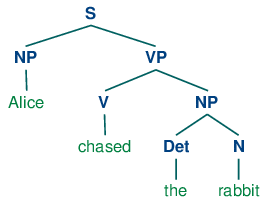

In [87]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch07-tree-3.png"))

*We use family metaphors for the relationships of nodes in a tree.  E.g., `S` is the __parent__ of `VP`, and `VP` is the child of `S`.  Since `NP` and `VP` are both __children__ of `S`, we could say they are __siblings__. Here is a text form for specifying trees:*

```
(S
   (NP Alice)
   (VP
      (V chased)
      (NP
         (Det the)
         (N rabbit))))
```

*To create a tree in NLTK, give a node label and a list of children:*

In [88]:
tree1 = nltk.Tree('NP', ['Alice'])
print(tree1)

(NP Alice)


In [89]:
tree2 = nltk.Tree('NP', ['the', 'rabbit'])
print(tree2)

(NP the rabbit)


*These can be incorporated into larger trees:*

In [90]:
tree3 = nltk.Tree('VP', ['chased', tree2])
tree4 = nltk.Tree('S', [tree1, tree3])
print(tree4)

(S (NP Alice) (VP chased (NP the rabbit)))


*Methods for trees:*

In [91]:
print(tree4[1])

(VP chased (NP the rabbit))


In [92]:
tree4[1].label()

'VP'

In [93]:
tree4.leaves()

['Alice', 'chased', 'the', 'rabbit']

In [94]:
tree4[1][1][1]

'rabbit'

*There is also of course the `tree.draw()` method.*

#### 4.3 Tree Traversal

*It is standard to use a recursive function to traverse a tree:*

*__N.B.:__ Code is not working.*

```
def traverse(t):
    try:
        t.label()
    except AttributeError:
        print(t, end = " ")
    else:
        # Now we know that t.node is defined
        print('(', t.label(), end = " ")
        for child in t:
            traverse(child)
        print(')', end = " ")
        
t = nltk.Tree('(S (NP Alice) (VP chased (NP the rabbit)))')
traverse(t)
```

### 5 Named Entity Recognition

*Commonly Used Types of NE:*

| __NE Type__      | __Examples__                                |
|:-------------|:----------------------------------------|
| ORGANIZATION | *Georgia-Pacific Corp., WHO*              |
| PERSON       | *Eddy Bonte, President Obama*             |
| LOCATION     | *Murray River, Mount Everest*             |
| DATE         | *June, 2008-06-29*                        |
| TIME         | *two fifty a m, 1:30 p.m.*                |
| MONEY        | *175 million Canadian Dollars, GBP 10.40* |
| PERCENT      | *twenty pct, 18.75 %*                     |
| FACILITY     | *Washington Monument, Stonehenge*         |
| GPE          | *South East Asia, Midlothian*             |

*It is common to use a __gazetteer__, or geographical dictionary, to identify NEs.  However, this is not error free:*

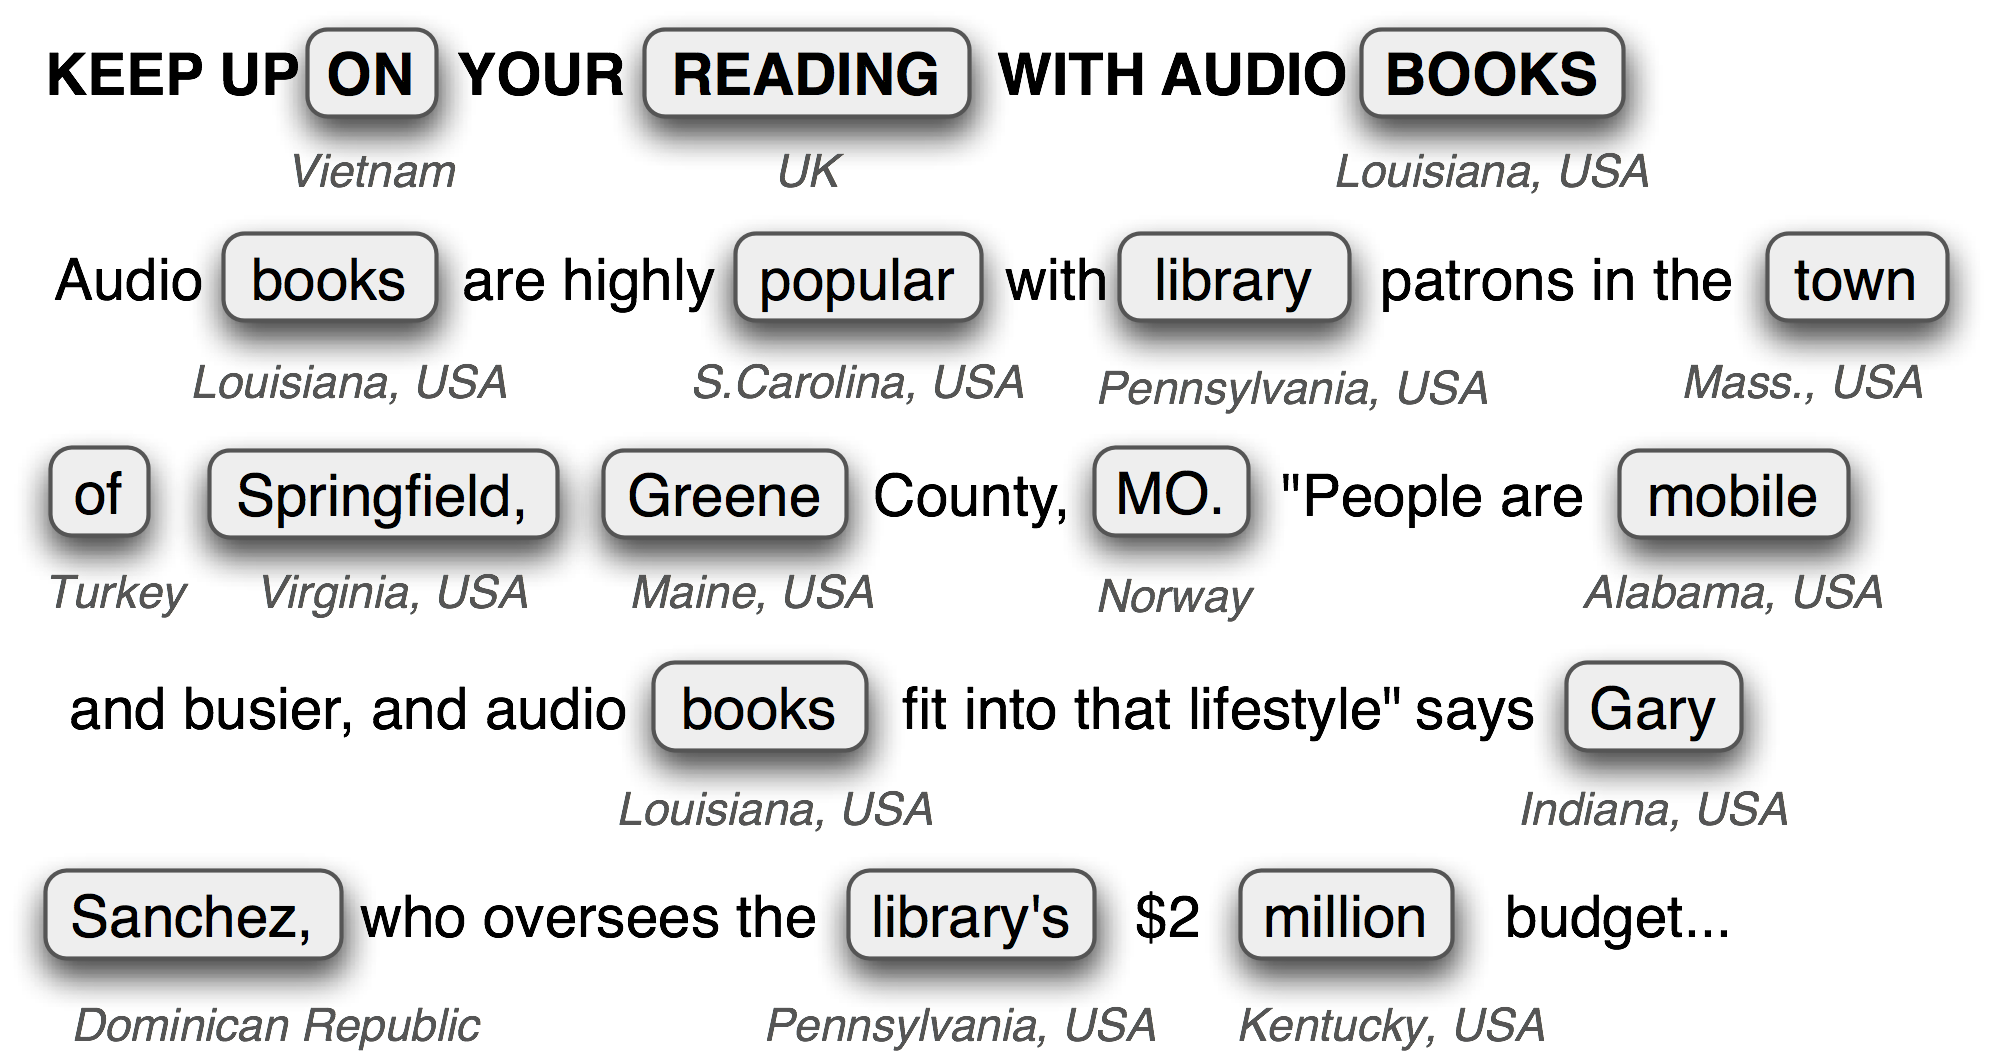

In [104]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\locations.png"))

*Another problem is that while certain entries almost surely belong to specific categories, there may be some ambiguity.  E.g., __May__ is most likely part of DATE, but it could also be a PERSON.  Similarly, __Christian Dior__ looks like a PERSON, but it's more likely an ORGANIZATION.*

*We can also use the IOB format for NEs:*

```
Eddy N B-PER
Bonte N I-PER
is V O
woordvoerder N O
van Prep O
diezelfde Pron O
Hogeschool N B-ORG
. Punc O
```

*There is a classifier that has been trainined to recognize named entities, and we can access it with `nltk.ne_chunk()`.  If we set `binary = True`, then NEs are tagged as `NE`.  Otherwise labels are used:*

In [105]:
sent = nltk.corpus.treebank.tagged_sents()[22]
print(nltk.ne_chunk(sent, binary = True))

(S
  The/DT
  (NE U.S./NNP)
  is/VBZ
  one/CD
  of/IN
  the/DT
  few/JJ
  industrialized/VBN
  nations/NNS
  that/WDT
  *T*-7/-NONE-
  does/VBZ
  n't/RB
  have/VB
  a/DT
  higher/JJR
  standard/NN
  of/IN
  regulation/NN
  for/IN
  the/DT
  smooth/JJ
  ,/,
  needle-like/JJ
  fibers/NNS
  such/JJ
  as/IN
  crocidolite/NN
  that/WDT
  *T*-1/-NONE-
  are/VBP
  classified/VBN
  *-5/-NONE-
  as/IN
  amphobiles/NNS
  ,/,
  according/VBG
  to/TO
  (NE Brooke/NNP)
  T./NNP
  Mossman/NNP
  ,/,
  a/DT
  professor/NN
  of/IN
  pathlogy/NN
  at/IN
  the/DT
  (NE University/NNP)
  of/IN
  (NE Vermont/NNP College/NNP)
  of/IN
  (NE Medicine/NNP)
  ./.)


In [106]:
print(nltk.ne_chunk(sent))

(S
  The/DT
  (GPE U.S./NNP)
  is/VBZ
  one/CD
  of/IN
  the/DT
  few/JJ
  industrialized/VBN
  nations/NNS
  that/WDT
  *T*-7/-NONE-
  does/VBZ
  n't/RB
  have/VB
  a/DT
  higher/JJR
  standard/NN
  of/IN
  regulation/NN
  for/IN
  the/DT
  smooth/JJ
  ,/,
  needle-like/JJ
  fibers/NNS
  such/JJ
  as/IN
  crocidolite/NN
  that/WDT
  *T*-1/-NONE-
  are/VBP
  classified/VBN
  *-5/-NONE-
  as/IN
  amphobiles/NNS
  ,/,
  according/VBG
  to/TO
  (PERSON Brooke/NNP T./NNP Mossman/NNP)
  ,/,
  a/DT
  professor/NN
  of/IN
  pathlogy/NN
  at/IN
  the/DT
  (ORGANIZATION University/NNP)
  of/IN
  (PERSON Vermont/NNP College/NNP)
  of/IN
  (GPE Medicine/NNP)
  ./.)


### 6 Relation Extraction

*Below is code that will find triples in the form (X __in__ Y). The regex `(?!\b.+ing)` is negative lookahead assertion that allows us to ignore strings where __in__ is followed by a gerund.*

In [107]:
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus = 'ieer', pattern = IN):
        print(nltk.sem.rtuple(rel))


[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


*Since the `conll2002` Dutch corpus has NE annotation and POS tags, we can devise patterns sensitive to these tags.  `.clause()` allows us to print the relations in a clausal form.  The parameter `relsym` specifies the binary relation symbol.*

In [108]:
from nltk.corpus import conll2002
vnv = """
(
is/V|      # 3rd sing present and
was/V|     # past forms of the verb zijn ('be')
werd/V     # and also present
wordt/V    # past of worden ('become')
)
.*         # followed by anything
van/Prep   # followed by van ('of')
"""
VAN = re.compile(vnv, re.VERBOSE)
for doc in conll2002.chunked_sents('ned.train'):
    for rel in nltk.sem.extract_rels('PER', 'ORG', doc,
                                     corpus = 'conll2002', pattern = VAN):
        print(nltk.sem.clause(rel, relsym = "VAN"))

VAN("cornet_d'elzius", 'buitenlandse_handel')
VAN('johan_rottiers', 'kardinaal_van_roey_instituut')


__Your Turn:__ Replace the last line by `print(nltk.rtuple(rel, lcon=True, rcon=True))`. This will show you the actual words that intervene between the two NEs and also their left and right context, within a default 10-word window. With the help of a Dutch dictionary, you might be able to figure out why the result `VAN('annie_lennox', 'eurythmics')` is a false hit.

*Actually, the code no longer returns `VAN('annie_lennox', 'eurythmics')`, so it's not possible to see why it's a false hit.*

### 7 Summary

*__No notes.__*

### 8 Further Reading

*__No notes.__*

### 9 Exercises

##### 1. 

☼ The IOB format categorizes tagged tokens as `I`, `O` and `B`. Why are three tags necessary? What problem would be caused if we used `I` and `O` tags exclusively?

*One issue that would arise with using only `I` and `O` tags is that it would be impossible to distinguish one long chunk from two smaller chunks immediately adjacent to each other, because there would be no tag identifying the boundary.*

##### 2. 

☼ Write a tag pattern to match noun phrases containing plural head nouns, e.g. "many/JJ researchers/NNS", "two/CD weeks/NNS", "both/DT new/JJ positions/NNS". Try to do this by generalizing the tag pattern that handled singular noun phrases.

*This grammar is designed to work only with the examples in this exercise, and will likely fail when applied to general sentences.*

In [110]:
grammar = r"""
    NP: {<DT>?<CD|JJ><NN.>}
"""
cp = nltk.RegexpParser(grammar)

In [111]:
nps =[[("many", "JJ"), ("researchers", "NNS")], 
      [("two", "CD"), ("weeks", "NNS")], 
      [("both", "DT"), ("new", "JJ"), ("positions", "NNS")]]

for n in nps:
    print(cp.parse(n))

(S (NP many/JJ researchers/NNS))
(S (NP two/CD weeks/NNS))
(S (NP both/DT new/JJ positions/NNS))


##### 3.

☼ Pick one of the three chunk types in the CoNLL corpus. Inspect the CoNLL corpus and try to observe any patterns in the POS tag sequences that make up this kind of chunk. Develop a simple chunker using the regular expression chunker `nltk.RegexpParser`. Discuss any tag sequences that are difficult to chunk reliably.

*Inspect the first 20 sentences in the corpus:*

In [114]:
from nltk.corpus import conll2000
for i in range(20):
    print(i, conll2000.chunked_sents('train.txt', chunk_types = ['VP'])[i])

0 (S
  Confidence/NN
  in/IN
  the/DT
  pound/NN
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  another/DT
  sharp/JJ
  dive/NN
  if/IN
  trade/NN
  figures/NNS
  for/IN
  September/NNP
  ,/,
  due/JJ
  for/IN
  release/NN
  tomorrow/NN
  ,/,
  (VP fail/VB to/TO show/VB)
  a/DT
  substantial/JJ
  improvement/NN
  from/IN
  July/NNP
  and/CC
  August/NNP
  's/POS
  near-record/JJ
  deficits/NNS
  ./.)
1 (S
  Chancellor/NNP
  of/IN
  the/DT
  Exchequer/NNP
  Nigel/NNP
  Lawson/NNP
  's/POS
  restated/VBN
  commitment/NN
  to/TO
  a/DT
  firm/NN
  monetary/JJ
  policy/NN
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  a/DT
  freefall/NN
  in/IN
  sterling/NN
  over/IN
  the/DT
  past/JJ
  week/NN
  ./.)
2 (S
  But/CC
  analysts/NNS
  (VP reckon/VBP)
  underlying/VBG
  support/NN
  for/IN
  sterling/NN
  (VP has/VBZ been/VBN eroded/VBN)
  by/IN
  the/DT
  chancellor/NN
  's/POS
  failure/NN
  (VP to/TO announce/VB)
  any/DT
  new/JJ
  policy/NN
  measures/NNS
  in/IN
  his/PRP$
  Mansio

*The most common patterns I observed were:

* __verbs alone:__

`(VP rose/VBD)`

* __verbs preceded by auxiliary verbs:__

`(VP are/VBP topped/VBN)`
`(VP has/VBZ been/VBN eroded/VBN)`

* __verbs preceded by modals:__ 

`(VP could/MD be/VB)`

* __verbs followed with the infinitive:__

`(VP has/VBZ helped/VBN to/TO prevent/VB)`
`(VP being/VBG forced/VBN to/TO increase/VB)`

* __verbs preceded by adverbs:__*
`(VP is/VBZ widely/RB expected/VBN to/TO take/VB)`

*It would be difficult to craft regex patterns to capture all possible patterns, let alone the most common ones.*

*Let's try with a naive approach, using tags that begin with the letters that are characteristic of VP tags:*


In [118]:
grammar = r"VP: {<[VRMT].*>+}"
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  94.3%%
    Precision:     64.2%%
    Recall:        80.4%%
    F-Measure:     71.4%%


*The parser does quite well, with a very high accuracy and recall.  However, its precision score is quite low.*

*Let's try a more convoluted model that will attempts to use common tags in the places where they are most often found:*

In [130]:
grammar = r"VP: {<VB.>?<RB>*<MD>?<VB.>?<TO>?<VB.>}"
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.3%%
    Precision:     74.4%%
    Recall:        66.8%%
    F-Measure:     70.4%%


*The precision is significantly higher, but all other metrics have decreased slightly, or in the case of recall, significantly.*

*Let's try to account for all of the types of adverb which we may encounter:*

In [125]:
grammar = r"VP: {<VB.>?<RB.>*<MD>?<VB.>?<TO>?<VB.>}"
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.4%%
    Precision:     72.7%%
    Recall:        66.9%%
    F-Measure:     69.7%%


*Pretty much a wash: half of the metrics went up slightly, the other half down slightly.*

*Let's try adding a possible modal just after `<TO>?`:*

In [127]:
grammar = r"VP: {<VB.>?<RB>*<MD>?<VB.>?<TO>?<MD>?<RB>*<VB.>}"
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.3%%
    Precision:     74.6%%
    Recall:        66.9%%
    F-Measure:     70.5%%


*Again, nothing but slight changes. I have the feeling we could go on forever like this, making slight adjustments without creating any huge breakthroughs.*

*Although this wasn't specified in the instructions, I'm curious to see what would happen if we used unigram and bigram chunkers:*

In [131]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['VP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types = ['VP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  94.3%%
    Precision:     60.5%%
    Recall:        74.2%%
    F-Measure:     66.7%%


In [132]:
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  96.5%%
    Precision:     75.1%%
    Recall:        85.7%%
    F-Measure:     80.0%%


*The best scores I had for my `RegexpParser` were comparable to ones produced by the `UnigramChunker`, but the `BigramChunker` blew them all out of the water.  As was the case with POS taggers, regex classifiers seem to lag behind $n$-gram classifiers.*

##### 4. 

☼ An early definition of *chunk* was the material that occurs between chinks. Develop a chunker that starts by putting the whole sentence in a single chunk, and then does the rest of its work solely by chinking. Determine which tags (or tag sequences) are most likely to make up chinks with the help of your own utility program. Compare the performance and simplicity of this approach relative to a chunker based entirely on chunk rules.

*The practically simplest way to chink sentences would be to exclude verbs and prepositions.*

In [1]:
import nltk, re
from nltk.corpus import conll2000

In [103]:
grammar = r"""
  NP: 
    {<.*>+}          
    }<VB.|IN>+{           
  """

cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  65.5%%
    Precision:     32.6%%
    Recall:        26.0%%
    F-Measure:     28.9%%


*We didn't spend much time analyzing the mistakes of the parsers in this unit, nor did we spend a lot of time on extracting information from the parser.  So coming up with a "utility program" to analyze mistakes was no trivial task, and in the end I wasn't able to get anything.  The biggest part of the problem was that I wasn't sure what to compare. The test sentences and the parsed sentences always had the same part of speech tags, so there was no point comparing those.  The structure of the trees was of course different, but it wasn't clear how these were to be compared.  I tried using `.subtrees()` and `tree2conlltags` to get the IOB tags, but the problem with this is that the IOB tags are different depending upon which level of the tree we are in.  I thought it might be possible to use some recursive function to drill into the layers of the tree, but this will actually go all the way down to the individual letters of the words in the sentence, which will all be labeled `O`. So for the moment I'll put this problem on the back burner.*

*What I ended up using as a stopgap was the `.incorrect()` method which was introduced in question 7.  I looked at the first 20 incorrect parses, and tried to identify any tags that may have cause the chinker to incorrectly parse the sentence.  I repeated this step several times, and for the sake of space I won't leave all the steps in this notebook.*

In [106]:
cp.evaluate(test_sents).incorrect()[20:40]

[ImmutableTree('NP', [('a', 'DT'), ('clean-fuels', 'NNS')]),
 ImmutableTree('NP', [('keep', 'VB'), ('the', 'DT'), ('firm', 'NN'), ("'s", 'POS'), ('180,000', 'CD'), ('Jaguar', 'NNP'), ('shares', 'NNS')]),
 ImmutableTree('NP', [('New', 'NNP'), ('York', 'NNP'), ('developer', 'NN'), ('Donald', 'NNP'), ('Trump', 'NNP'), ("'s", 'POS'), ('decision', 'NN')]),
 ImmutableTree('NP', [('a', 'DT'), ('dozen', 'NN'), ('more', 'RBR')]),
 ImmutableTree('NP', [('Some', 'DT')]),
 ImmutableTree('NP', [('use', 'VB')]),
 ImmutableTree('NP', [('be', 'VB')]),
 ImmutableTree('NP', [('offering', 'NN'), ('yields', 'NNS'), ('half', 'PDT'), ('a', 'DT'), ('percentage', 'NN'), ('point', 'NN')]),
 ImmutableTree('NP', [('87.25', 'CD')]),
 ImmutableTree('NP', [('some', 'DT'), ('people', 'NNS'), ('familiar', 'JJ')]),
 ImmutableTree('NP', [('8.9', 'CD'), ('billion', 'CD')]),
 ImmutableTree('NP', [('1.6', 'CD'), ('billion', 'CD')]),
 ImmutableTree('NP', [('April', 'NNP'), ('gold', 'NN'), ('contracts', 'NNS')]),
 Immutable

In [279]:
grammar = r"""
  NP: 
    {<.*>+}          
    }<VB.|IN|,|.|CC|TO|''|MD|``|RB|>+{           
  """

cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt', chunk_types = ['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  85.6%%
    Precision:     64.8%%
    Recall:        68.0%%
    F-Measure:     66.3%%


*As was the case earlier, I used trial and error to settle upon the tags above.*

##### 5.

◑ Write a tag pattern to cover noun phrases that contain gerunds, e.g. "the/DT receiving/VBG end/NN", "assistant/NN managing/VBG editor/NN". Add these patterns to the grammar, one per line. Test your work using some tagged sentences of your own devising.

In [118]:
grammar = """
    NP: {<DT><VBG><NN>}    # chunk determiner, gerund, and noun
        {<NN><VBG><NN>}    # chunk noun, gerund, and noun
"""
cp = nltk.RegexpParser(grammar)
sentences = [[("the", "DT"), ("receiving", "VBG"), ("end", "NN")], 
             [("assistant", "NN"),  ("managing", "VBG"),  ("editor", "NN")]]

for sent in sentences:
    print(cp.parse(sent))

(S (NP the/DT receiving/VBG end/NN))
(S (NP assistant/NN managing/VBG editor/NN))


*It would be quite simple to create a one-line regular expression that can handle this:*

In [119]:
import re

grammar = r"""
    NP: {<DT|NN><VBG><NN>}    # chunk determiner/noun, gerund, and noun
"""
cp = nltk.RegexpParser(grammar)
sentences = [[("the", "DT"), ("receiving", "VBG"), ("end", "NN")], 
             [("assistant", "NN"),  ("managing", "VBG"),  ("editor", "NN")]]

for sent in sentences:
    print(cp.parse(sent))

(S (NP the/DT receiving/VBG end/NN))
(S (NP assistant/NN managing/VBG editor/NN))


*Sentences of my own:*

In [114]:
sentences = [[("a", "DT"), ("thriving", "VBG"), ("metropolis", "NN")], 
             [("temporary", "NN"),  ("acting", "VBG"),  ("director", "NN")]]

for sent in sentences:
    print(cp.parse(sent))

(S (NP a/DT thriving/VBG metropolis/NN))
(S (NP temporary/NN acting/VBG director/NN))


##### 6. 

◑ Write one or more tag patterns to handle coordinated noun phrases, e.g. "July/NNP and/CC August/NNP", "all/DT your/PRP\$ managers/NNS and/CC supervisors/NNS", "company/NN courts/NNS and/CC adjudicators/NNS".

In [125]:
grammar = """
    NP: {<DT>?<PRP.>?<NN.*>+<CC><NN.>} # Chunk coordinated noun phrases
"""
cp = nltk.RegexpParser(grammar)
sentences = [[("July", "NNP"),  ("and", "CC"), ("August", "NNP")], 
             [("all", "DT"), ("your", "PRP$"), ("managers", "NNS"), 
              ("and", "CC"), ("supervisors", "NNS")], 
             [("company", "NN"), ("courts", "NNS"), 
              ("and", "CC"), ("adjudicators", "NNS")]]

for sent in sentences:
    print(cp.parse(sent))


(S (NP July/NNP and/CC August/NNP))
(S (NP all/DT your/PRP$ managers/NNS and/CC supervisors/NNS))
(S (NP company/NN courts/NNS and/CC adjudicators/NNS))


##### 7. 

◑ Carry out the following evaluation tasks for any of the chunkers you have developed earlier. (Note that most chunking corpora contain some internal inconsistencies, such that any reasonable rule-based approach will produce errors.)

* a. Evaluate your chunker on 100 sentences from a chunked corpus, and report the precision, recall and F-measure.

* b. Use the `chunkscore.missed()` and `chunkscore.incorrect()` methods to identify the errors made by your chunker. Discuss.

* c. Compare the performance of your chunker to the baseline chunker discussed in the evaluation section of this chapter.

*Part a.:*

In [126]:
grammar = r"VP: {<VB.>?<RB>*<MD>?<VB.>?<TO>?<MD>?<RB>*<VB.>}"
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt'[:100], chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.3%%
    Precision:     74.6%%
    Recall:        66.9%%
    F-Measure:     70.5%%


*Part b. Looking at the missed and incorrect chunks, no patterns that I could easily incorporate jump out at me:*

In [128]:
cp.evaluate(test_sents).missed()[:20]

[ImmutableTree('VP', [('frequently', 'RB'), ('attempting', 'VBG'), ('to', 'TO'), ('enforce', 'VB')]),
 ImmutableTree('VP', [('must', 'MD'), ('have', 'VB'), ('found', 'VBN')]),
 ImmutableTree('VP', [('did', 'VBD'), ("n't", 'RB'), ('expect', 'VB')]),
 ImmutableTree('VP', [('priced', 'VBN'), ('to', 'TO'), ('yield', 'VB')]),
 ImmutableTree('VP', [('is', 'VBZ'), ('threatening', 'VBG'), ('to', 'TO'), ('veto', 'VB')]),
 ImmutableTree('VP', [('decide', 'VBP'), ('to', 'TO'), ('work', 'VB')]),
 ImmutableTree('VP', [('to', 'TO'), ('continue', 'VB'), ('clutching', 'VBG')]),
 ImmutableTree('VP', [('are', 'VBP')]),
 ImmutableTree('VP', [('purchased', 'VBN')]),
 ImmutableTree('VP', [('to', 'TO'), ('congratulate', 'VB')]),
 ImmutableTree('VP', [('Hardest', 'RBS'), ('hit', 'VBN')]),
 ImmutableTree('VP', [('are', 'VBP'), ("n't", 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('have', 'VB')]),
 ImmutableTree('VP', [('raping', 'VBG')]),
 ImmutableTree('VP', [('might', 'MD'), ('end', 'VB')]),
 ImmutableTree('VP

In [129]:
cp.evaluate(test_sents).incorrect()[:20]

[ImmutableTree('VP', [('operating', 'VBG')]),
 ImmutableTree('VP', [('did', 'VBD')]),
 ImmutableTree('VP', [('existing', 'VBG')]),
 ImmutableTree('VP', [('shows', 'VBZ')]),
 ImmutableTree('VP', [('held', 'VBN')]),
 ImmutableTree('VP', [('insured', 'VBN')]),
 ImmutableTree('VP', [('operating', 'VBG')]),
 ImmutableTree('VP', [('want', 'VBP')]),
 ImmutableTree('VP', [('also', 'RB'), ('are', 'VBP')]),
 ImmutableTree('VP', [('refuse', 'VBP')]),
 ImmutableTree('VP', [('scrambled', 'VBD')]),
 ImmutableTree('VP', [('had', 'VBD')]),
 ImmutableTree('VP', [('flared', 'VBN')]),
 ImmutableTree('VP', [('following', 'VBG')]),
 ImmutableTree('VP', [('once', 'RB'), ('breathed', 'VBD')]),
 ImmutableTree('VP', [('often', 'RB'), ('prepared', 'VBN')]),
 ImmutableTree('VP', [('elected', 'VBN')]),
 ImmutableTree('VP', [('based', 'VBN')]),
 ImmutableTree('VP', [('sold', 'VBN'), ('equals', 'VBZ')]),
 ImmutableTree('VP', [('presumed', 'VBN')])]

In [133]:
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt'[:100], chunk_types = ['VP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  84.6%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


*The accuracy seems surprisingly high, but this just means that approximately 85% of the words are not in a `VP` chunk.*

##### 8. 

◑ Develop a chunker for one of the chunk types in the CoNLL corpus using a regular-expression based chunk grammar `RegexpChunk`. Use any combination of rules for chunking, chinking, merging or splitting.

*I don't understand the difference between this question and question 3. The only thing that seems different is the inclusion of chinking, which seems less accurate than chunking. Also, we never discussed merging or splitting in this chapter, so I have no idea how to incorporate this.*

##### 9. 

◑ Sometimes a word is incorrectly tagged, e.g. the head noun in "12/CD or/CC so/RB cases/VBZ". Instead of requiring manual correction of tagger output, good chunkers are able to work with the erroneous output of taggers. Look for other examples of correctly chunked noun phrases with incorrect tags.

*I eyeballed a number of example sentences, and it felt like looking for a proverbial needle in a haystack. Instead of searching through 10,000 hard-to-read sentences for a rather rare phenomenon, I decided to use a programmatic solution. I tried a number of approaches before I figured out how to use regular expressions to find subtrees labelled as `NP` that had verbs, but no nouns.  The code feels rather gnarly, so I left detailed comments:*  

In [247]:
misses = []

for (i, sent) in enumerate(conll2000.chunked_sents('train.txt')):
    for subtree in sent:
        # only want subtrees, so use `try-except` to eliminate
        # single nodes
        try:
            subtree.label()
        except AttributeError:
            pass
        else:
            if subtree.label() == 'NP':
                # set flag only for NPs
                flag = True
                # exclude subtrees that have nouns, pronouns,
                # numbers, relative pronouns, etc...
                for leaf in subtree.leaves():
                    if re.match(r'NN|PRP|CD|WP|EX|DT', leaf[1]):
                        flag = False

        # the flag will only still be True if the subtree is a NP
        # and doesn't have a noun, pronoun, etc...
        # if it does have a verb, though, we'll want to 
        # inspect it
        if flag == True and re.match(r'VB.*', leaf[1]):
            # print the id and the subtree
            misses.append( (i, subtree) )
            # reset flag
            flag = False

*Looking at first ten instances:*

In [249]:
for m in misses[:10]:
    print(m)

(293, Tree('NP', [('estimates', 'VBZ')]))
(324, Tree('NP', [("'s", 'POS'), ('holding', 'VBG')]))
(498, Tree('NP', [('operating', 'VBG'), ('results', 'VBZ')]))
(524, Tree('NP', [("'s", 'POS'), ('backing', 'VBG')]))
(587, Tree('NP', [('offers', 'VBZ')]))
(611, Tree('NP', [("'s", 'VBZ')]))
(725, Tree('NP', [("'s", 'POS'), ('standing', 'VBG')]))
(827, Tree('NP', [('around', 'IN'), ('$', '$'), ('5', 'VBG')]))
(867, Tree('NP', [('trading', 'VBG')]))
(876, Tree('NP', [('employees', 'VBZ')]))


*Looking at the sentence with the first instance:*

In [236]:
print(conll2000.chunked_sents('train.txt')[293])

(S
  (PP As/IN)
  usual/JJ
  ,/,
  (NP estimates/VBZ)
  (PP on/IN)
  (NP the/DT fickle/JJ report/NN)
  (VP are/VBP)
  wide/JJ
  ,/,
  (VP running/VBG)
  (PP from/IN)
  (NP a/DT drop/NN)
  (PP of/IN)
  (NP 3.5/CD %/NN)
  (PP to/TO)
  (NP a/DT gain/NN)
  (PP of/IN)
  (NP 1.6/CD %/NN)
  ./.)


##### 10.

◑ The bigram chunker scores about 90% accuracy. Study its errors and try to work out why it doesn't get 100% accuracy. Experiment with trigram chunking. Are you able to improve the performance any more?

In [252]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                       for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)
        
    
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [255]:
test_sents = conll2000.chunked_sents('test.txt')
train_sents = conll2000.chunked_sents('train.txt')
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  89.3%%
    Precision:     81.2%%
    Recall:        86.2%%
    F-Measure:     83.6%%


In [258]:
cp.evaluate(test_sents).missed()[:20]

[ImmutableTree('NP', [('Mr.', 'NNP'), ('Turner', 'NNP')]),
 ImmutableTree('PP', [('in', 'IN')]),
 ImmutableTree('NP', [('a', 'DT'), ('decline', 'NN')]),
 ImmutableTree('PP', [('of', 'IN')]),
 ImmutableTree('NP', [('long-term', 'JJ'), ('``', '``'), ('bailout', 'NN'), ("''", "''"), ('bonds', 'NNS')]),
 ImmutableTree('NP', [('I', 'PRP')]),
 ImmutableTree('VP', [('must', 'MD'), ('have', 'VB'), ('found', 'VBN')]),
 ImmutableTree('NP', [('Merc', 'NN'), ('officials', 'NNS')]),
 ImmutableTree('NP', [('$', '$'), ('33', 'CD'), ('million', 'CD')]),
 ImmutableTree('NP', [('a', 'DT'), ('volunteer', 'NN'), ('patrol', 'NN')]),
 ImmutableTree('NP', [('about', 'IN'), ('10', 'CD')]),
 ImmutableTree('PP', [('for', 'IN')]),
 ImmutableTree('NP', [('the', 'DT'), ('first', 'JJ'), ('half', 'NN')]),
 ImmutableTree('NP', [('sales', 'NNS')]),
 ImmutableTree('NP', [('John', 'NNP'), ('Motley', 'NNP')]),
 ImmutableTree('NP', [('44', 'CD')]),
 ImmutableTree('PP', [('to', 'TO')]),
 ImmutableTree('NP', [('Other', 'JJ'

In [263]:
cp.evaluate(test_sents).incorrect()[:20]

[ImmutableTree('VP', [('operating', 'VBG')]),
 ImmutableTree('VP', [('did', 'VBD')]),
 ImmutableTree('VP', [('existing', 'VBG')]),
 ImmutableTree('VP', [('shows', 'VBZ')]),
 ImmutableTree('VP', [('held', 'VBN')]),
 ImmutableTree('VP', [('insured', 'VBN')]),
 ImmutableTree('VP', [('operating', 'VBG')]),
 ImmutableTree('VP', [('want', 'VBP')]),
 ImmutableTree('VP', [('also', 'RB'), ('are', 'VBP')]),
 ImmutableTree('VP', [('refuse', 'VBP')]),
 ImmutableTree('VP', [('scrambled', 'VBD')]),
 ImmutableTree('VP', [('had', 'VBD')]),
 ImmutableTree('VP', [('flared', 'VBN')]),
 ImmutableTree('VP', [('following', 'VBG')]),
 ImmutableTree('VP', [('once', 'RB'), ('breathed', 'VBD')]),
 ImmutableTree('VP', [('often', 'RB'), ('prepared', 'VBN')]),
 ImmutableTree('VP', [('elected', 'VBN')]),
 ImmutableTree('VP', [('based', 'VBN')]),
 ImmutableTree('VP', [('sold', 'VBN'), ('equals', 'VBZ')]),
 ImmutableTree('VP', [('presumed', 'VBN')])]

*Looking at the first 20 incorrect/missed, it's not very easy to see how we could improve the accuracy.*

*As for setting up a trigram chunker, it's very easy.  However, the trigram chunker is somewhat less accurate than the bigram chunker:*

In [259]:
class TrigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                       for sent in train_sents]
        self.tagger = nltk.TrigramTagger(train_data)
        
    
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [262]:
trigram_chunker = TrigramChunker(train_sents)
print(trigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     81.0%%
    Recall:        84.4%%
    F-Measure:     82.6%%


##### 11. 

★ Apply the n-gram and Brill tagging methods to IOB chunk tagging. Instead of assigning POS tags to words, here we will assign IOB tags to the POS tags. E.g. if the tag `DT` (determiner) often occurs at the start of a chunk, it will be tagged `B` (begin). Evaluate the performance of these chunking methods relative to the regular expression chunking methods covered in this chapter.

*Modified from the code supplied as an [answer to a question from this SO discussion](https://stackoverflow.com/a/40508641/9097207 "code from Brill Trainer API author"). This code was supplied by the author of NLTK's Brill Trainer api. I frankly don't think I could craft code like this from scratch at the moment, as the NLTK didn't spent that much time on the Brill Trainer, and some of the things they considered are no longer working.  In his SO response, the author of the Brill Trainer did give a quite lengthy answer, but I felt he could have gone into a little more detail regarding the inner workings of his code.*

In [12]:
import sys 

from nltk import tbl, untag
from nltk.tag.brill_trainer import BrillTaggerTrainer

from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags
from nltk.tag import DefaultTagger

def get_templates():
    
    pos10 = [[POS([0])],
             [POS([-1])],
             [POS([1])],
             [POS([-1]), POS([0])],
             [POS([0]), POS([1])],
             [POS([-1]), POS([1])],
             [POS([-2]), POS([-1])],
             [POS([1]), POS([2])],
             [POS([-1, -2, -3])],
             [POS([1, 2, 3])]]
    
    iobs5 = [[IOB([0])],
             [IOB([-1]), IOB([0])],
             [IOB([0]), IOB([1])],
             [IOB([-2]), IOB([-1])],
             [IOB([1]), IOB([2])]]
    
    templates = [tbl.Template(*pos + iob) for pos in pos10 for iob in iobs5]
    
    return templates

def build_multifeature_corpus():
    
    def tuple2dict_featureset(sent, tagnames = ("word", "pos", "trueiob")):
        return (dict(zip(tagnames, t)) for t in sent)
    
    def tag_tokens(tokens):
        return [(t, t["trueiob"]) for t in tokens]
    
    train_sents = conll2000.chunked_sents('train.txt')
    conlltagged_sents = (tree2conlltags(sent)
                        for sent in train_sents)
    conlltagged_tokens = (tuple2dict_featureset(sent) 
                        for sent in conlltagged_sents)
    conlltagged_sequences = (tag_tokens(sent)
                            for sent in conlltagged_tokens)
    
    return conlltagged_sequences

class POS(tbl.Feature):
    @staticmethod
    def extract_property(tokens, index):
        return tokens[index][0]["pos"]

class IOB(tbl.Feature):
    @staticmethod
    def extract_property(tokens, index):
        return tokens[index][1]
    

    
class MyInitialTagger(DefaultTagger):
    def choose_tag(self, tokens, index, history):
        tokens_ = [t["word"] for t in tokens]
        return super().choose_tag(tokens_, index, history)
    
    
templates = get_templates()
trainon = 100

corpus = list(build_multifeature_corpus())
train, test = corpus[:trainon], corpus[trainon:]

print(train[0], "\n")

initial_tagger = MyInitialTagger('O')
print(initial_tagger.tag(untag(train[0])), "\n")

trainer = BrillTaggerTrainer(initial_tagger, templates, trace = 3)
tagger = trainer.train(train)

taggedtest = tagger.tag_sents([untag(t) for t in test])
print(test[0])
print(initial_tagger.tag(untag(test[0])))
print(taggedtest[0])
print()

tagger.print_template_statistics()    

[({'word': 'Confidence', 'pos': 'NN', 'trueiob': 'B-NP'}, 'B-NP'), ({'word': 'in', 'pos': 'IN', 'trueiob': 'B-PP'}, 'B-PP'), ({'word': 'the', 'pos': 'DT', 'trueiob': 'B-NP'}, 'B-NP'), ({'word': 'pound', 'pos': 'NN', 'trueiob': 'I-NP'}, 'I-NP'), ({'word': 'is', 'pos': 'VBZ', 'trueiob': 'B-VP'}, 'B-VP'), ({'word': 'widely', 'pos': 'RB', 'trueiob': 'I-VP'}, 'I-VP'), ({'word': 'expected', 'pos': 'VBN', 'trueiob': 'I-VP'}, 'I-VP'), ({'word': 'to', 'pos': 'TO', 'trueiob': 'I-VP'}, 'I-VP'), ({'word': 'take', 'pos': 'VB', 'trueiob': 'I-VP'}, 'I-VP'), ({'word': 'another', 'pos': 'DT', 'trueiob': 'B-NP'}, 'B-NP'), ({'word': 'sharp', 'pos': 'JJ', 'trueiob': 'I-NP'}, 'I-NP'), ({'word': 'dive', 'pos': 'NN', 'trueiob': 'I-NP'}, 'I-NP'), ({'word': 'if', 'pos': 'IN', 'trueiob': 'O'}, 'O'), ({'word': 'trade', 'pos': 'NN', 'trueiob': 'B-NP'}, 'B-NP'), ({'word': 'figures', 'pos': 'NNS', 'trueiob': 'I-NP'}, 'I-NP'), ({'word': 'for', 'pos': 'IN', 'trueiob': 'B-PP'}, 'B-PP'), ({'word': 'September', 'pos': '

*I did examine the rules and played around with new chunkers to see if I could make new parsers with increased accuracy, but unfortunately I wasn't able to get anything that performed any better than the parsers we've been using.  I suspect there are two reason for this: one is that Brill Trainer examines the POS and IOB tags of previous and subsequent words, but we're not able to use this information when we hand craft our parsers. In addition, it's not so simple to tease the rules out of the Brill Trainer's output, as previous rules are often superceded by future rules.*

##### 12.

★ We saw in [5](https://www.nltk.org/book/ch05.html#chap-tag "Chapter 5") that it is possible to establish an upper limit to tagging performance by looking for ambiguous n-grams, n-grams that are tagged in more than one possible way in the training data. Apply the same method to determine an upper bound on the performance of an n-gram chunker.

*Looking at the IOB tags of the previous two words:*

In [35]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[2], y[2], z[0]), z[2])
           for sent in train_sents
           for x, y, z in nltk.trigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.35955948727207077

*Looking at the POS tags of the previous two words:*

In [33]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[1], y[1], z[0]), z[2])
           for sent in train_sents
           for x, y, z in nltk.trigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.22214427565573983

*Looking at both the IOB and POS tags of the previous two words:*

In [34]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[1], x[2], y[1], y[2], z[0]), z[2])
           for sent in train_sents
           for x, y, z in nltk.trigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.15939442395481393

*Looking at just the IOB tag of the previous word:*

In [37]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[2], y[0]), y[2])
           for sent in train_sents
           for x, y in nltk.bigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.43632113851206417

*Looking at just the POS tag of the previous word:*

In [38]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[1], y[0]), y[2])
           for sent in train_sents
           for x, y in nltk.bigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.3850516048542588

*Looking at the POS and IOB tag of the previous word:*

In [39]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[1], x[2], y[0]), y[2])
           for sent in train_sents
           for x, y in nltk.bigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.27115601777199183

*From these experiments we can see that there is quite a bit of ambiguity with IOB tags.  Looking at the tags of the previous two words is more unambiguous than looking at just the tag of the last word, and looking at both the POS and IOB tags is more unambiguous than looking at either just the POS or IOB tags. As might be expected, ambiguity is very low if we look at __the previous words and their tags__:*

In [40]:
train_sents = conll2000.chunked_sents('train.txt')
cfd = nltk.ConditionalFreqDist(
           ((x[0], x[1], x[2], y[0], y[1], y[2], z[0]), z[2])
           for sent in train_sents
           for x, y, z in nltk.trigrams(tree2conlltags(sent)))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.005591519872075929

##### 13. 

★ Pick one of the three chunk types in the CoNLL corpus. Write functions to do the following tasks for your chosen type:

* a. List all the tag sequences that occur with each instance of this chunk type.

* b. Count the frequency of each tag sequence, and produce a ranked list in order of decreasing frequency; each line should consist of an integer (the frequency) and the tag sequence.

* c. Inspect the high-frequency tag sequences. Use these as the basis for developing a better chunker.

*__a.__ I'll focus on `NP`s.  Below is code similar to what I used in exercise 9 to find `NP`s within the sentences. I'll extract the POS tags from the words in `NP`s and store their values inside concatenated strings.  This will make things easier later when I use `set()` to get the number of unique tag sequences.  My initial inclination was to use lists of tags instead of strings, but `set()` won't work on nested lists.*

In [70]:
np_tags = []

for (i, sent) in enumerate(conll2000.chunked_sents('train.txt')):
    for subtree in sent:
        # only want subtrees, so use `try-except` to eliminate
        # single nodes
        try:
            subtree.label()
        except AttributeError:
            pass
        else:
            if subtree.label() == 'NP':
                # concatenating a string with all the POS tags
                subtree_tag = ""
                for t in tree2conlltags(subtree):
                    if subtree_tag == "":
                        subtree_tag += t[1]
                    else:
                        subtree_tag += "/" + t[1]
                np_tags.append(subtree_tag)

In [72]:
len(set(np_tags))

2283

*__b.__ With 2283 distinct POS-tag combinations, I'm obviously not going to print all of them out.  With instructions like these, I often wonder if the authors attempted these exercises themselves before assigning them... For the sake of brevity, I'll just print out the first 200, but it would be a trivial exercise to print all of the tags:*

In [127]:
fd = nltk.FreqDist(np_tags)
for tag, value in fd.most_common(50):
    print("{:>4} {}".format(value, tag))

7223 DT/NN
3802 PRP
3282 NNS
3249 NNP
3245 NN
2642 NNP/NNP
2119 DT/JJ/NN
1722 JJ/NNS
1173 DT/NNS
1143 JJ/NN
1012 NN/NNS
 930 WDT
 921 DT/NN/NN
 866 CD
 830 CD/NN
 824 $/CD/CD
 690 CD/NNS
 677 NNP/NNP/NNP
 624 PRP$/NN
 552 POS/NN
 540 DT
 509 WP
 463 DT/NNP
 454 NN/NN
 446 $/CD
 399 DT/NNP/NN
 355 PRP$/NNS
 313 JJ/NN/NNS
 311 DT/NNP/NNP
 277 DT/JJ/NN/NN
 276 DT/JJ/NNS
 220 NNP/NNP/NNP/NNP
 204 POS/NNS
 200 CD/CD
 195 PRP$/JJ/NN
 189 EX
 183 NNP/CD
 183 NNP/NNS
 182 DT/JJ/JJ/NN
 171 POS/JJ/NN
 161 DT/NN/NNS
 158 DT/NNP/NNP/NNP
 149 JJ/JJ/NN
 146 JJ/JJ/NNS
 141 DT/VBN/NN
 124 DT/CD/NNS
 124 IN
 115 NNP/NN
 113 NNP/CC/NNP
 113 POS/NN/NN


In [128]:
grammar = r"""
    NP: {<DT|PRP$|POS|$|WP|EX>?<JJ.*>*<CD>*<NN.*|WDT>*<CD>*}
"""
cp = nltk.RegexpParser(grammar)
test_sents = conll2000.chunked_sents('test.txt'[:100], chunk_types = ['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.6%%
    Precision:     71.9%%
    Recall:        74.1%%
    F-Measure:     73.0%%


*By looking at the most common tag sequences, it is possible to generate regexes that will cover most occurrences.  However, if we try to cover every possible occurrence, we increase the number of false positives returned, which will drive down the accuracy metrics.  For example, it's possible that prepositions or verbs will occur within noun phrases.  However, including tags for these POS will drive down the accuracy considerably.*

*I'd like to finish this book before the end of the year, so to reach that goal I've decided to postpone working on some of the more difficult questions until I've finished the rest of the book.*

##### 14. 

★ The baseline chunker presented in the evaluation section tends to create larger chunks than it should. For example, the phrase: `[every/DT time/NN] [she/PRP] sees/VBZ [a/DT newspaper/NN]` contains two consecutive chunks, and our baseline chunker will incorrectly combine the first two: `[every/DT time/NN she/PRP]`. Write a program that finds which of these chunk-internal tags typically occur at the start of a chunk, then devise one or more rules that will split up these chunks. Combine these with the existing baseline chunker and re-evaluate it, to see if you have discovered an improved baseline.

##### 15.

★ Develop an `NP` chunker that converts POS-tagged text into a list of tuples, where each tuple consists of a verb followed by a sequence of noun phrases and prepositions, e.g. `the little cat sat on the mat` becomes (`'sat'`, `'on'`, `'NP'`)...

##### 16.

★ The Penn Treebank contains a section of tagged Wall Street Journal text that has been chunked into noun phrases. The format uses square brackets, and we have encountered it several times during this chapter. The Treebank corpus can be accessed using: `for sent in nltk.corpus.treebank_chunk.chunked_sents(fileid)`. These are flat trees, just as we got using `nltk.corpus.conll2000.chunked_sents()`.

* a. The functions `nltk.tree.pprint()` and `nltk.chunk.tree2conllstr()` can be used to create Treebank and IOB strings from a tree. Write functions `chunk2brackets()` and `chunk2iob()` that take a single chunk tree as their sole argument, and return the required multi-line string representation.

* b. Write command-line conversion utilities `bracket2iob.py` and `iob2bracket.py` that take a file in Treebank or CoNLL format (resp) and convert it to the other format. (Obtain some raw Treebank or CoNLL data from the NLTK Corpora, save it to a file, and then use `for line in open(filename)` to access it from Python.)

*Color me confused.  If I follow the instructions above to letter, the IPython interpreter throws an error:*

```
nltk.tree.pprint(nltk.corpus.treebank_chunk.chunked_sents()[0])

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-158-32f265c33d32> in <module>
----> 1 nltk.tree.pprint(nltk.corpus.treebank_chunk.chunked_sents()[0])

AttributeError: module 'nltk.tree' has no attribute 'pprint'
```

*But if I modify the syntax somewhat, it works:*

In [159]:
nltk.tree.Tree.pprint(nltk.corpus.treebank_chunk.chunked_sents()[0])

(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)


*But the output is the same as just using `print`:*

In [160]:
print(nltk.corpus.treebank_chunk.chunked_sents()[0])

(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)


In [157]:


for sent in nltk.corpus.treebank_chunk.chunked_sents()[:10]:
    nltk.tree.Tree.pprint(sent)
    print(sent)

(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)
(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)
(S
  (NP Mr./NNP Vinken/NNP)
  is/VBZ
  (NP chairman/NN)
  of/IN
  (NP Elsevier/NNP N.V./NNP)
  ,/,
  (NP the/DT Dutch/NNP publishing/VBG group/NN)
  ./.)
(S
  (NP Mr./NNP Vinken/NNP)
  is/VBZ
  (NP chairman/NN)
  of/IN
  (NP Elsevier/NNP N.V./NNP)
  ,/,
  (NP the/DT Dutch/NNP publishing/VBG group/NN)
  ./.)
(S
  (NP Rudolph/NNP Agnew/NNP)
  ,/,
  (NP 55/CD years/NNS)
  old/JJ
  and/CC
  (NP former/JJ chairman/NN)
  of/IN
  (NP Consolidated/NNP Gold/NNP Fields/NNP PLC/NNP)
  ,/,
  was/VBD
  named/VBN
  (NP a/DT nonexecutive/JJ director/NN)
  of/IN
  (NP this/DT British/JJ industrial/JJ conglomerate/NN)
  ./.)
(S
  

In [4]:
print(nltk.chunk.tree2conllstr(nltk.corpus.treebank_chunk.chunked_sents()[0]))

Pierre NNP B-NP
Vinken NNP I-NP
, , O
61 CD B-NP
years NNS I-NP
old JJ O
, , O
will MD O
join VB O
the DT B-NP
board NN I-NP
as IN O
a DT B-NP
nonexecutive JJ I-NP
director NN I-NP
Nov. NNP I-NP
29 CD I-NP
. . O


In [3]:
print(conll2000.chunked_sents('train.txt')[0])

(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)


##### 17. 

★ An n-gram chunker can use information other than the current part-of-speech tag and the $n-1$ previous chunk tags. Investigate other models of the context, such as the $n-1$ previous part-of-speech tags, or some combination of previous chunk tags along with previous and following part-of-speech tags.

##### 18. 

★ Consider the way an n-gram tagger uses recent tags to inform its tagging choice. Now observe how a chunker may re-use this sequence information. For example, both tasks will make use of the information that nouns tend to follow adjectives (in English). It would appear that the same information is being maintained in two places. Is this likely to become a problem as the size of the rule sets grows? If so, speculate about any ways that this problem might be addressed.